In [27]:
import open3d as o3d
import numpy as np
import pandas as pd
#import functions as f
import matplotlib.pyplot as plt
#from scipy.interpolate import interp1d
import seqpc

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [28]:
facemocap_df = pd.read_pickle('facemocap_df.pkl')
facemocap_df.sample(10)

,File name,Original SPC,Name,Experimentator,MoCap platform,Pathology,Repetitive,Movement,Date
148,FRS02_M3.csv,"[[479.931, -55.7091, 1184.77, 486.518, -45.435...",FRS02,François-Régis,UTC,False,False,3,11-06-2014
22,PS01_M4.csv,"[[108.423, 33.5088, 1105.03, 94.2414, 21.0263,...",PS01,François-Régis,UTC,False,False,4,NaN
29,NL01_M1.csv,"[[361.744, -74.2685, 1126.08, 348.253, -89.9, ...",NL01,François-Régis,UTC,False,False,1,11-06-2014
75,AD01_M1bis.csv,"[[233.789, 16.0804, 1173.06, 241.165, 40.3077,...",AD01,François-Régis,UTC,False,False,1,NaN
78,QS_M1.csv,"[[97.9104, -7.71903, 1161.73, 97.062, -5.31282...",QS,François-Régis,UTC,False,False,1,NaN
276,s01_s1_std.csv,"[[58.4088, 375.736, 631.023, 44.0266, 371.459,...",AC01,François-Régis,UTC,False,False,,13-05-2014
230,SB01_M3.csv,"[[121.034, -0.845705, 1108.22, 129.57, 21.4672...",SB01,François-Régis,UTC,False,False,3,NaN
2,P13_D1_M1x10e1.csv,"[[9.69796, 177.153, 597.488, 9.15275, 160.08, ...",NaN,Mattieu,UTC,Facial palsy,False,1,NaN
1,P20_D1_M3x10e9.csv,"[[-72.3368, 182.864, 672.873, -73.6713, 163.98...",NaN,Mattieu,UTC,Facial palsy,False,3,NaN
309,M5_03.csv,"[[215.234, 75.6975, 1129.57, 190.846, 79.5354,...",AF,Félix,IFF,False,False,5,NaN


In [29]:
# Store the values in df["Original SPC"] as a list of arrays if 'Pathology' is False
list_health = np.array(facemocap_df.loc[facemocap_df['Pathology'] == False, "Original SPC"].values)
print(len(list_health))

317


In [30]:
list_pc = []
for i in range(len(list_health)): # these loops can be highly improved
    for t in range(len(list_health[i])):
        pc_original = list_health[i][t].reshape(108, 3)
        ref_frame_points = np.copy(pc_original[:3])
        selected_points = np.copy(pc_original[3:-4])
        pc_dental_frame = seqpc.change_reference_frame(selected_points, ref_frame_points)
        list_pc.append(pc_dental_frame)
point_cloud_data = np.array(list_pc)
point_cloud_data = point_cloud_data.reshape(-1, 303)
print(point_cloud_data.shape)


(218890, 303)


In [31]:
# Find the rows in point_cloud_data that contain only NaN values
nan_rows = []
for i in range(len(point_cloud_data)):
    if np.all(np.isnan(point_cloud_data[i])):
        nan_rows.append(i)
print(len(nan_rows)) 

1338


In [32]:
# Remove the rows in point_cloud_data that contain only NaN values
point_cloud_data = np.delete(point_cloud_data, nan_rows, axis=0)
# Select a radom sample of 50000 rows 
point_cloud_data = point_cloud_data[np.random.choice(point_cloud_data.shape[0], 50000, replace=False), :]
print(point_cloud_data.shape)

(50000, 303)


In [33]:
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [34]:
point_cloud_data = np.where(point_cloud_data == 'nan', np.nan, point_cloud_data)

C:\Users\ederro\AppData\Local\Temp\ipykernel_9748\2849329339.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  point_cloud_data = np.where(point_cloud_data == 'nan', np.nan, point_cloud_data)


In [35]:
# Scale the data (optional, but can improve performance)
scaler = StandardScaler()
point_cloud_data_scaled = scaler.fit_transform(point_cloud_data)

In [36]:
# Impute missing values using KNN
k = 5  # Number of nearest neighbors to consider
imputer = KNNImputer(n_neighbors=k)
point_cloud_data_imputed_scaled = imputer.fit_transform(point_cloud_data_scaled)

In [37]:
# Inverse transform the scaled data back to original scale
point_cloud_data_imputed = scaler.inverse_transform(point_cloud_data_imputed_scaled)

In [43]:
# Find the nans values in point_cloud_data[index]
index = 1
nan_rows = []
for i in range(len(point_cloud_data[index])):
    if np.isnan(point_cloud_data[index][i]):
        nan_rows.append(i)
print(nan_rows)
# Assign the index to the labels


[171, 172, 173]


In [45]:
# labels = seqpc.get_labels()
target_labels = labels[3:-4]

[171, 172, 173]


In [58]:
for i in range(len(nan_rows[::3])):
    print(nan_rows[::3][i]//3)
    print(target_labels[nan_rows[::3][i]//3])

57
"Dao2"


In [ ]:
import pickle
save = False
if save:
    # Save point_cloud_data_imputed and point_cloud_data to a pickle file
    with open('point_cloud_data_imputed.pkl', 'wb') as f:
        pickle.dump(point_cloud_data_imputed, f)

    with open('point_cloud_data.pkl', 'wb') as f:
        pickle.dump(point_cloud_data, f)



In [68]:
pcdi = point_cloud_data_imputed[index].reshape(-1, 3)
pcd = point_cloud_data[index].reshape(-1, 3)
pc = o3d.geometry.PointCloud()
v3d = o3d.utility.Vector3dVector
pc.points = v3d(pcdi)
o3d.visualization.draw_geometries([pc])

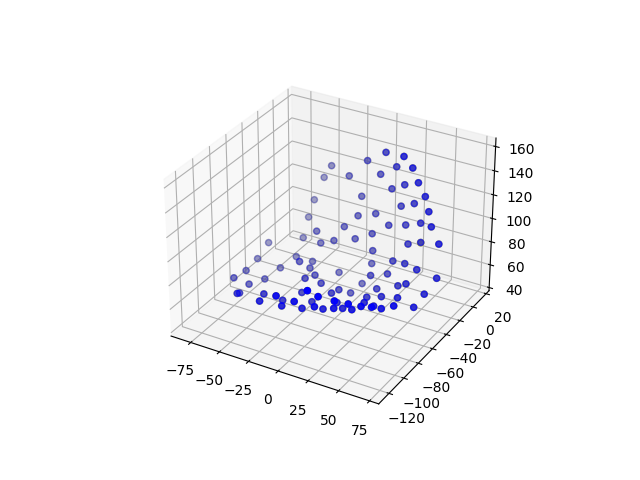

In [59]:
# Now 'point_cloud_data_imputed' contains the dataset with the missing values estimated using KNN
%matplotlib widget

pcd = point_cloud_data[index].reshape(-1, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcdi[3:, 0], pcdi[3:, 1], pcdi[3:, 2], c='y')
ax.scatter(pcd[3:, 0], pcd[3:, 1], pcd[3:, 2], c='b')
plt.show()

# Experimental

In [72]:

pc.colors = v3d(np.tile([1, 0, 0], (len(pcdi), 1)))
#pc.colors = v3d(np.tile([0, 1, 0], (len(pcdi)-10, 1)))
o3d.visualization.draw_geometries([pc])